# Day 6: Factor-Based Allocation
## Week 5: Portfolio Optimization

---

**Learning Objectives:**
- Understand factor-based portfolio construction
- Implement factor exposure targeting
- Build factor momentum strategies
- Combine factors for multi-factor portfolios

In [1]:
# Day 6 Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

TRADING_DAYS = 252
RF_RATE = 0.05

# Load data
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                 index_col='Date', parse_dates=True)

assets = ['AAPL', 'MSFT', 'JPM', 'XOM', 'GLD', 'TLT']
prices = df[assets].dropna()
returns = prices.pct_change().dropna()

print("=" * 60)
print("FACTOR-BASED ALLOCATION - DAY 6")
print("=" * 60)

FACTOR-BASED ALLOCATION - DAY 6


## 1. Creating Synthetic Factors

In [2]:
# Create simple factors from our data
print("=" * 60)
print("CREATING FACTORS")
print("=" * 60)

# We'll create factor proxies from our data
# Market factor: SPY returns
spy = df['SPY'].pct_change().dropna()

# Size factor proxy: Small-cap spread (simulated)
# We'll use the spread between smaller and larger stocks
size_factor = (returns['JPM'] + returns['XOM']) / 2 - (returns['AAPL'] + returns['MSFT']) / 2

# Value factor proxy: High yield spread
# Using TLT as bond proxy
value_factor = returns['JPM'] - returns['MSFT']  # Banks vs Tech

# Momentum factor: Cross-sectional momentum
def calculate_momentum(returns, lookback=252):
    """Calculate momentum scores."""
    # Past 12-month return, skip recent month
    mom = returns.rolling(lookback).sum().shift(21)
    return mom

momentum_scores = calculate_momentum(returns, 252)

# Align all data
factors = pd.DataFrame({
    'Market': spy,
    'Size': size_factor,
    'Value': value_factor
}).loc[returns.index].dropna()

# Align returns with factors
aligned_returns = returns.loc[factors.index]

print(f"\nFactor correlation with Market:")
print(factors.corr()['Market'].round(3))

print(f"\n📊 Factor Statistics:")
factor_stats = factors.agg(['mean', 'std']) * np.array([[TRADING_DAYS], [np.sqrt(TRADING_DAYS)]])
print(factor_stats.round(4))

CREATING FACTORS

Factor correlation with Market:
Market    1.000
Size     -0.168
Value    -0.051
Name: Market, dtype: float64

📊 Factor Statistics:
      Market    Size   Value
mean  0.1794 -0.0832 -0.0289
std   0.1973  0.2901  0.3117


## 2. Factor Exposure Analysis

FACTOR EXPOSURE ANALYSIS

📊 Factor Betas:
      Market   Size  Value
AAPL   1.068 -0.738  0.370
MSFT   1.118 -0.008 -0.412
JPM    1.118 -0.008  0.588
XOM    1.068  1.262 -0.630
GLD    0.093  0.064 -0.094
TLT   -0.144 -0.089 -0.030


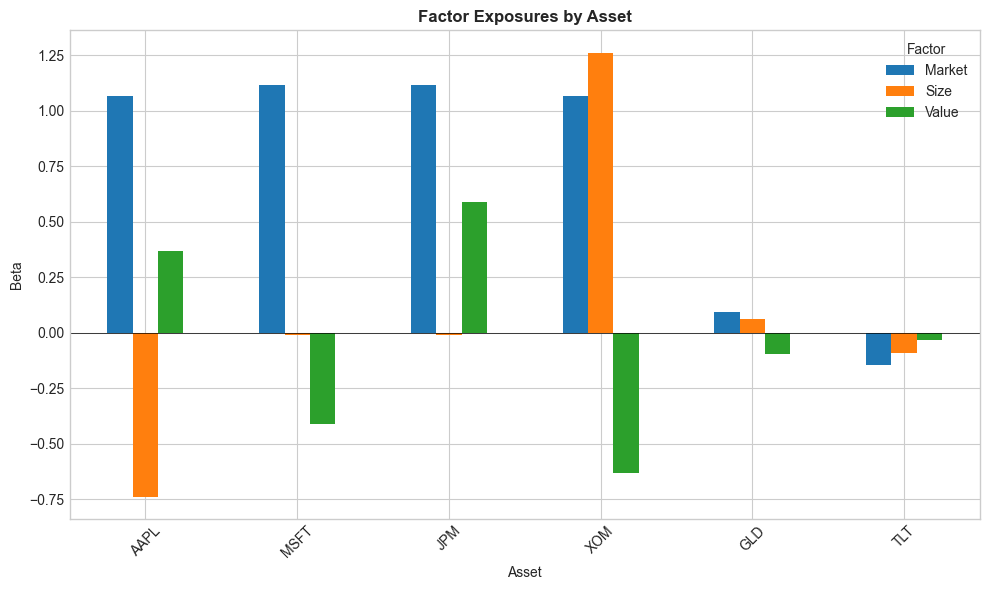

In [3]:
# Calculate factor exposures for each asset
print("=" * 60)
print("FACTOR EXPOSURE ANALYSIS")
print("=" * 60)

def calculate_factor_betas(asset_returns, factor_returns):
    """Calculate factor loadings via regression."""
    X = factor_returns.values
    y = asset_returns.values
    
    model = LinearRegression()
    model.fit(X, y)
    
    return pd.Series(model.coef_, index=factor_returns.columns)

# Calculate betas for each asset
betas = {}
for asset in assets:
    asset_ret = aligned_returns[asset]
    betas[asset] = calculate_factor_betas(asset_ret, factors)

betas_df = pd.DataFrame(betas).T

print("\n📊 Factor Betas:")
print(betas_df.round(3))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
betas_df.plot(kind='bar', ax=ax)
ax.set_title('Factor Exposures by Asset', fontweight='bold')
ax.set_ylabel('Beta')
ax.set_xlabel('Asset')
ax.legend(title='Factor')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Target Factor Portfolio

In [4]:
# Build portfolio with target factor exposures
print("=" * 60)
print("TARGET FACTOR PORTFOLIO")
print("=" * 60)

def target_factor_portfolio(betas_df, target_exposures, cov_matrix):
    """
    Find portfolio weights to achieve target factor exposures
    while minimizing tracking error.
    """
    n_assets = len(betas_df)
    B = betas_df.values  # N x K matrix
    target = np.array(target_exposures)  # K x 1
    
    def objective(w):
        # Minimize portfolio variance
        return np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # weights sum to 1
    ]
    
    # Add factor exposure constraints
    for i, factor in enumerate(betas_df.columns):
        constraints.append({
            'type': 'eq',
            'fun': lambda w, idx=i: np.dot(w, B[:, idx]) - target[idx]
        })
    
    bounds = tuple((-0.5, 0.5) for _ in range(n_assets))  # Allow short selling
    
    result = minimize(objective, np.array([1/n_assets]*n_assets), method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result.x

# Define target exposures
cov = aligned_returns.cov().values * TRADING_DAYS

# Target: High market beta, positive value tilt, low size
target_exposures = [1.0, -0.1, 0.3]  # Market, Size, Value

target_weights = target_factor_portfolio(betas_df, target_exposures, cov)

print(f"\n📊 Target Exposures: Market={target_exposures[0]}, Size={target_exposures[1]}, Value={target_exposures[2]}")
print(f"\n📊 Optimal Weights:")
for asset, weight in zip(assets, target_weights):
    print(f"  {asset}: {weight:.2%}")

# Verify achieved exposures
achieved_exposures = betas_df.T.dot(target_weights)
print(f"\n📊 Achieved Exposures:")
for factor, exposure in achieved_exposures.items():
    print(f"  {factor}: {exposure:.3f}")

TARGET FACTOR PORTFOLIO

📊 Target Exposures: Market=1.0, Size=-0.1, Value=0.3

📊 Optimal Weights:
  AAPL: 25.31%
  MSFT: 8.56%
  JPM: 49.86%
  XOM: 7.25%
  GLD: 5.22%
  TLT: 3.81%

📊 Achieved Exposures:
  Market: 1.000
  Size: -0.100
  Value: 0.300


## 4. Factor Momentum Strategy

In [5]:
# Factor momentum strategy
print("=" * 60)
print("FACTOR MOMENTUM STRATEGY")
print("=" * 60)

def factor_momentum_weights(returns, lookback=60):
    """
    Calculate weights based on recent momentum.
    Long winners, short losers.
    """
    # Calculate momentum scores
    mom_scores = returns.rolling(lookback).sum()
    
    # Rank and normalize
    ranks = mom_scores.rank(axis=1)
    n_assets = len(returns.columns)
    
    # Center ranks to create long-short weights
    centered = ranks - (n_assets + 1) / 2
    
    # Normalize to sum to 1 (long-only version)
    long_weights = ranks / ranks.sum(axis=1).values.reshape(-1, 1)
    
    return long_weights, mom_scores

# Calculate momentum weights over time
mom_weights, mom_scores = factor_momentum_weights(aligned_returns, lookback=60)
mom_weights = mom_weights.dropna()

# Backtest momentum strategy
mom_returns = (mom_weights.shift(1) * aligned_returns.loc[mom_weights.index]).sum(axis=1).dropna()

# Equal weight for comparison
ew_returns = aligned_returns.loc[mom_returns.index].mean(axis=1)

# Compare performance
print(f"\n📊 Strategy Comparison:")
for name, strat_ret in [('Momentum', mom_returns), ('Equal Weight', ew_returns)]:
    ann_ret = strat_ret.mean() * TRADING_DAYS
    ann_vol = strat_ret.std() * np.sqrt(TRADING_DAYS)
    sharpe = (ann_ret - RF_RATE) / ann_vol
    print(f"  {name}: Ann.Return={ann_ret:.2%}, Vol={ann_vol:.2%}, Sharpe={sharpe:.3f}")

FACTOR MOMENTUM STRATEGY

📊 Strategy Comparison:
  Momentum: Ann.Return=19.93%, Vol=15.34%, Sharpe=0.973
  Equal Weight: Ann.Return=19.09%, Vol=15.48%, Sharpe=0.910


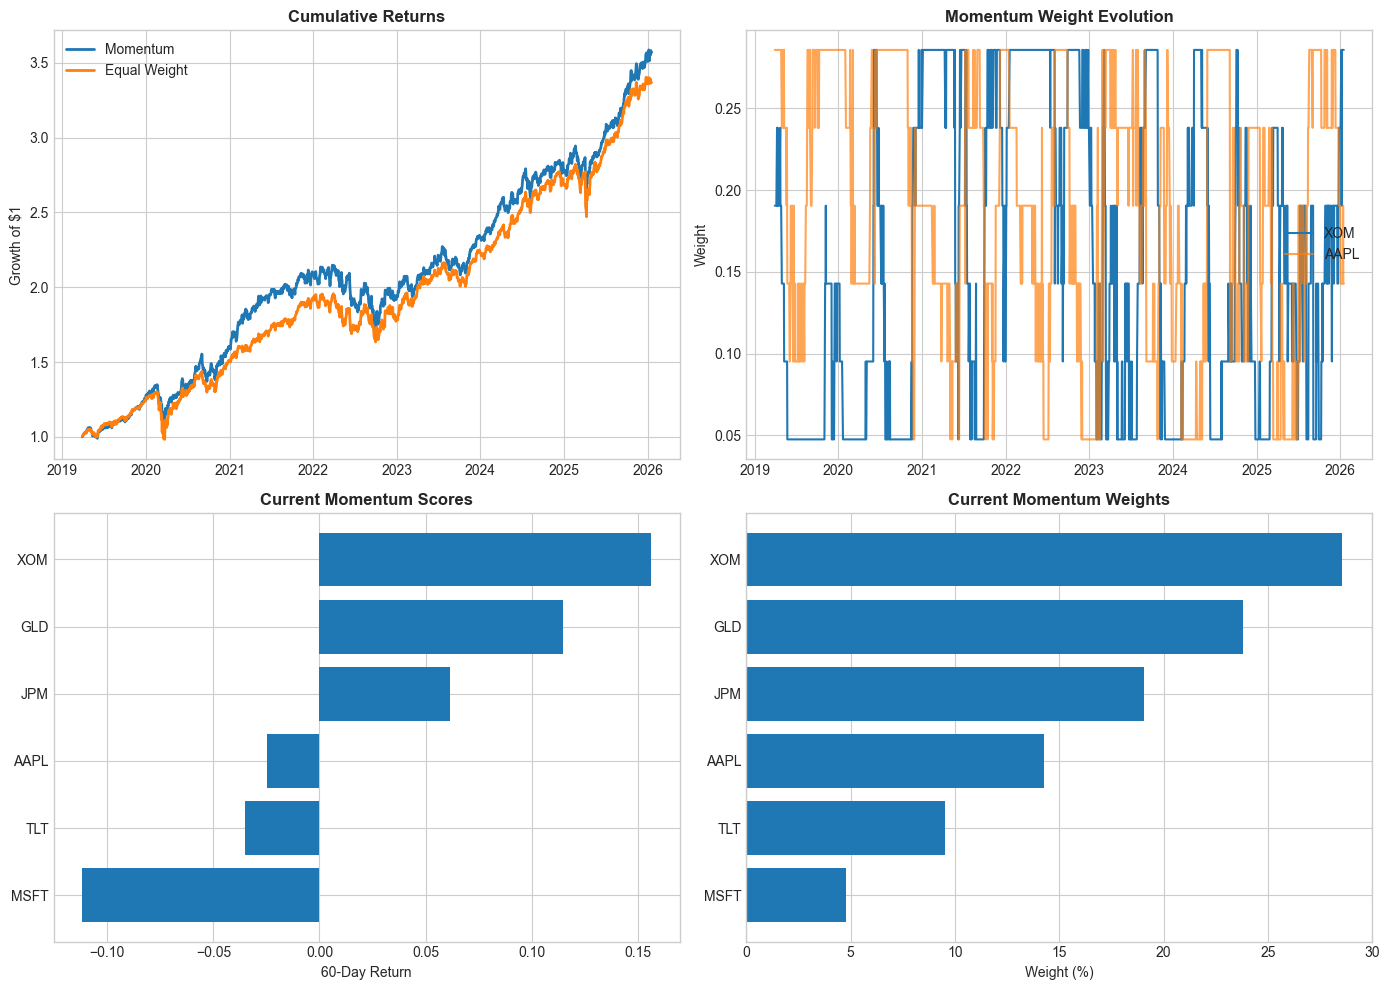

In [6]:
# Visualize momentum strategy
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cumulative returns
cum_mom = (1 + mom_returns).cumprod()
cum_ew = (1 + ew_returns).cumprod()

axes[0, 0].plot(cum_mom.index, cum_mom.values, label='Momentum', linewidth=2)
axes[0, 0].plot(cum_ew.index, cum_ew.values, label='Equal Weight', linewidth=2)
axes[0, 0].set_title('Cumulative Returns', fontweight='bold')
axes[0, 0].set_ylabel('Growth of $1')
axes[0, 0].legend()

# Weight evolution for top asset
top_asset = mom_weights.iloc[-1].idxmax()
axes[0, 1].plot(mom_weights[top_asset], label=top_asset)
axes[0, 1].plot(mom_weights[assets[0]], label=assets[0], alpha=0.7)
axes[0, 1].set_title('Momentum Weight Evolution', fontweight='bold')
axes[0, 1].set_ylabel('Weight')
axes[0, 1].legend()

# Current momentum scores
current_scores = mom_scores.iloc[-1].sort_values()
axes[1, 0].barh(current_scores.index, current_scores.values)
axes[1, 0].set_title('Current Momentum Scores', fontweight='bold')
axes[1, 0].set_xlabel('60-Day Return')

# Current weights
current_weights = mom_weights.iloc[-1].sort_values()
axes[1, 1].barh(current_weights.index, current_weights.values * 100)
axes[1, 1].set_title('Current Momentum Weights', fontweight='bold')
axes[1, 1].set_xlabel('Weight (%)')

plt.tight_layout()
plt.show()

## 5. Multi-Factor Portfolio

In [7]:
# Multi-factor portfolio construction
print("=" * 60)
print("MULTI-FACTOR PORTFOLIO")
print("=" * 60)

def create_factor_scores(returns, lookback=60):
    """
    Create multiple factor scores for assets.
    """
    scores = pd.DataFrame(index=returns.index, columns=returns.columns)
    
    # Momentum factor (past returns)
    momentum = returns.rolling(lookback).sum()
    
    # Volatility factor (inverse vol - low vol preferred)
    volatility = -returns.rolling(lookback).std()  # Negative so low vol = high score
    
    # Mean reversion factor (short-term reversal)
    reversal = -returns.rolling(5).sum()  # Negative of recent return
    
    return {
        'Momentum': momentum,
        'Low Vol': volatility,
        'Reversal': reversal
    }

def combine_factors(factor_dict, factor_weights):
    """
    Combine factor scores into composite score.
    """
    # Normalize each factor cross-sectionally
    normalized = {}
    for name, scores in factor_dict.items():
        # Z-score normalization
        mean = scores.mean(axis=1)
        std = scores.std(axis=1)
        normalized[name] = scores.sub(mean, axis=0).div(std, axis=0)
    
    # Weighted combination
    composite = None
    for name, weight in factor_weights.items():
        if composite is None:
            composite = normalized[name] * weight
        else:
            composite += normalized[name] * weight
    
    return composite

# Calculate factor scores
factor_scores = create_factor_scores(aligned_returns, lookback=60)

# Define factor weights
factor_weights = {
    'Momentum': 0.4,
    'Low Vol': 0.4,
    'Reversal': 0.2
}

# Get composite score
composite = combine_factors(factor_scores, factor_weights)

# Convert to weights (softmax-like)
def scores_to_weights(scores):
    """Convert scores to portfolio weights."""
    # Rank-based weights
    ranks = scores.rank(axis=1)
    weights = ranks / ranks.sum(axis=1).values.reshape(-1, 1)
    return weights

multi_factor_weights = scores_to_weights(composite).dropna()

# Backtest multi-factor strategy
mf_returns = (multi_factor_weights.shift(1) * aligned_returns.loc[multi_factor_weights.index]).sum(axis=1).dropna()

print(f"\n📊 Multi-Factor Strategy Performance:")
ann_ret = mf_returns.mean() * TRADING_DAYS
ann_vol = mf_returns.std() * np.sqrt(TRADING_DAYS)
sharpe = (ann_ret - RF_RATE) / ann_vol
print(f"  Ann. Return: {ann_ret:.2%}")
print(f"  Ann. Volatility: {ann_vol:.2%}")
print(f"  Sharpe Ratio: {sharpe:.3f}")

print(f"\n📊 Current Multi-Factor Weights:")
current_mf = multi_factor_weights.iloc[-1].sort_values(ascending=False)
for asset, weight in current_mf.items():
    print(f"  {asset}: {weight:.2%}")

MULTI-FACTOR PORTFOLIO

📊 Multi-Factor Strategy Performance:
  Ann. Return: 17.30%
  Ann. Volatility: 13.26%
  Sharpe Ratio: 0.927

📊 Current Multi-Factor Weights:
  TLT: 28.57%
  GLD: 23.81%
  AAPL: 19.05%
  JPM: 14.29%
  XOM: 9.52%
  MSFT: 4.76%


## 📝 Key Takeaways - Day 6

### Factor-Based Allocation:
1. **Factor Exposure**: Measure sensitivity to systematic factors
2. **Target Portfolios**: Build portfolios with specific factor tilts
3. **Factor Momentum**: Time factor exposure based on performance
4. **Multi-Factor**: Combine multiple signals for diversification

### Common Factors:
| Factor | Definition | Premium Source |
|--------|------------|----------------|
| Market | Beta to market | Risk compensation |
| Size | Small vs Large | Liquidity premium |
| Value | Cheap vs Expensive | Mean reversion |
| Momentum | Winners vs Losers | Behavioral |
| Low Vol | Low vs High volatility | Leverage constraints |

### Interview Questions:
- "How do you construct a factor-neutral portfolio?"
- "What is factor momentum and how does it differ from cross-sectional momentum?"
- "How would you combine multiple factors?"